In [1]:
import numpy as np
import pandas as pd

In [2]:
df_10k = pd.read_csv('./bag_of_words_full.csv', index_col=0)
df_10k.head()

,mention,watch,episode,right,exactly,happen,thing,scene,violence,set,word,pull,drug,sex,classic,use,state,focus,city,face,high,home,italian,death,far,away,main,appeal,fact,forget,pretty,picture,audience,romance,mess,develop,taste,level,sell,kill,...,crew,history,jane,copy,realistic,chase,location,choice,footage,blue,badly,cat,sci,fi,sexual,escape,road,scream,attention,t,step,society,recently,adaptation,powerful,party,park,portrayal,science,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott,sentiment_target
0,1,3,2,2,1,1,1,1,4,1,2,1,1,1,1,1,1,1,2,1,2,1,1,1,1,2,1,1,1,3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
2,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,negative
4,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,positive


In [3]:
df_10k.describe()

,mention,watch,episode,right,exactly,happen,thing,scene,violence,set,word,pull,drug,sex,classic,use,state,focus,city,face,high,home,italian,death,far,away,main,appeal,fact,forget,pretty,picture,audience,romance,mess,develop,taste,level,sell,kill,...,answer,crew,history,jane,copy,realistic,chase,location,choice,footage,blue,badly,cat,sci,fi,sexual,escape,road,scream,attention,t,step,society,recently,adaptation,powerful,party,park,portrayal,science,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.00000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.060760,0.554300,0.098740,0.137980,0.039280,0.141620,0.329960,0.428340,0.042420,0.136560,0.074120,0.037300,0.03626,0.069540,0.081340,0.092460,0.041860,0.036640,0.050500,0.090160,0.100920,0.076440,0.02406,0.086200,0.120800,0.11036,0.092260,0.022880,0.147020,0.053860,0.145560,0.076460,0.104660,0.02976,0.029540,0.032040,0.021440,0.048020,0.022720,0.135920,...,0.024660,0.02786,0.052060,0.02104,0.031980,0.030300,0.031940,0.026220,0.02768,0.027040,0.023900,0.025620,0.024640,0.028160,0.028320,0.026820,0.0346,0.020260,0.02506,0.036660,0.021700,0.022380,0.028440,0.022920,0.020180,0.024680,0.028200,0.02028,0.023380,0.021760,0.021700,0.020540,0.028900,0.023460,0.02544,0.02366,0.022180,0.025200,0.020640,0.021640
std,0.274426,0.910773,0.563877,0.422167,0.210945,0.441234,0.699611,0.923299,0.255933,0.422889,0.304939,0.208013,0.30415,0.381297,0.323737,0.341341,0.241555,0.217574,0.304026,0.348014,0.375044,0.327168,0.22619,0.386694,0.388292,0.36357,0.351099,0.164673,0.440374,0.248275,0.456307,0.336179,0.394245,0.20336,0.183815,0.195075,0.159565,0.252973,0.172408,0.508341,...,0.193009,0.21458,0.271645,0.31591,0.209089,0.196119,0.230653,0.175651,0.18065,0.221517,0.205255,0.180012,0.241649,0.226292,0.226537,0.202735,0.2220,0.169027,0.19275,0.201288,0.203543,0.182647,0.203941,0.155162,0.178699,0.176385,0.213648,0.20127,0.166715,0.196894,0.161461,0.154527,0.358423,0.186414,0.18120,0.18028,0.184198,0.173913,0.154449,0.236501
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0

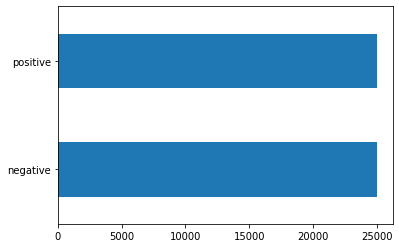

In [4]:
df_10k.sentiment_target.value_counts().plot(kind = 'barh')

In [5]:
n = 15000
df_positive = df_10k[df_10k['sentiment_target'] == 'positive'].sample(n=n)
df_negative = df_10k[df_10k['sentiment_target'] == 'negative'].sample(n=n)

df_sample_test = df_positive.append(df_negative)
df_sample_test.describe()

,mention,watch,episode,right,exactly,happen,thing,scene,violence,set,word,pull,drug,sex,classic,use,state,focus,city,face,high,home,italian,death,far,away,main,appeal,fact,forget,pretty,picture,audience,romance,mess,develop,taste,level,sell,kill,...,answer,crew,history,jane,copy,realistic,chase,location,choice,footage,blue,badly,cat,sci,fi,sexual,escape,road,scream,attention,t,step,society,recently,adaptation,powerful,party,park,portrayal,science,search,basic,vampire,color,maker,channel,culture,dramatic,intelligent,scott
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.00000,30000.000000
mean,0.060500,0.553433,0.097767,0.138667,0.039700,0.142233,0.327500,0.422967,0.042733,0.137967,0.073933,0.036667,0.036167,0.069900,0.081633,0.092833,0.040933,0.035667,0.051533,0.089300,0.100500,0.073867,0.023867,0.083900,0.121967,0.110600,0.093933,0.023600,0.144767,0.053600,0.14420,0.074733,0.105700,0.029867,0.028800,0.030300,0.020600,0.048467,0.022633,0.135833,...,0.023767,0.028167,0.052233,0.022967,0.031933,0.031833,0.031800,0.025967,0.026867,0.025467,0.024700,0.024600,0.02550,0.028400,0.028633,0.027933,0.033600,0.019533,0.024900,0.036833,0.022567,0.022267,0.028000,0.021867,0.020500,0.022833,0.027800,0.020500,0.023067,0.021267,0.021700,0.020233,0.029200,0.022733,0.026033,0.022367,0.023367,0.026900,0.02030,0.022433
std,0.275395,0.908206,0.554694,0.426432,0.213835,0.439783,0.697754,0.921174,0.257377,0.424584,0.305183,0.206697,0.325365,0.372763,0.324817,0.342373,0.226994,0.215707,0.310828,0.349852,0.366339,0.318978,0.226050,0.377093,0.387938,0.367113,0.360436,0.170814,0.434376,0.246433,0.45645,0.332694,0.398245,0.203738,0.182679,0.188635,0.154843,0.259589,0.172980,0.518451,...,0.177959,0.216737,0.273692,0.337307,0.210195,0.200719,0.220281,0.173474,0.179664,0.211391,0.215309,0.175488,0.25466,0.229336,0.230250,0.209176,0.225254,0.164983,0.190476,0.201357,0.206540,0.186830,0.199041,0.151842,0.184971,0.167072,0.203048,0.196675,0.164729,0.187124,0.161545,0.152397,0.361965,0.184980,0.188034,0.172629,0.193275,0.181597,0.15107,0.255993
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

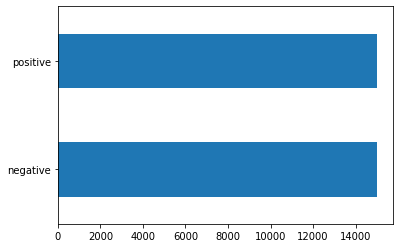

In [6]:
df_sample_test.sentiment_target.value_counts().plot(kind = 'barh')

## SIA

In [7]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

In [8]:
df_reviews = pd.read_csv('./IMDB Dataset.csv')
df_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [11]:
df_reviews_test = df_reviews.iloc[df_sample_test.index]
df_reviews_test.head()

,review,sentiment
17144,The main problem I see with this film is its s...,positive
49659,"I saw Beyond Rangoon about 20 times, it was TH...",positive
35966,It has been about 50 years since a movie has b...,positive
35534,I was delighted when I saw that my husband ren...,positive
27358,It's a movie with a theatrical message blended...,positive


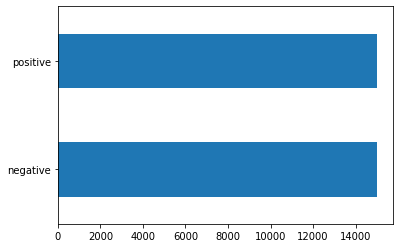

In [12]:
df_reviews_test.sentiment.value_counts().plot(kind = 'barh')

In [17]:
sia = SentimentIntensityAnalyzer()

corrects = 0

for index, row in df_reviews_test.iterrows():
    sentiment_dict = sia.polarity_scores(row['review'])

    # Ideia da analise https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
    if (sentiment_dict['compound'] >= 0.05 and row['sentiment'] == 'positive') or (sentiment_dict['compound'] <= - 0.05 and row['sentiment'] == 'negative'): 
        corrects += 1

acuracia = corrects/df_reviews_test.shape[0]

In [19]:
print(f"Corretos: {corrects}")
print(f"Total: {df_reviews_test.shape[0]}")
print(f"Acurácia: {acuracia}")

Corretos: 20746
Total: 30000
Acurácia: 0.6915333333333333


## Classificadores

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier

In [ ]:
def return_features(df_train, df_test):
    oe = OrdinalEncoder()

    y_train = oe.fit_transform(df_train.sentiment_target.values.reshape(-1, 1))
    y_test = oe.transform(df_test.sentiment_target.values.reshape(-1, 1))
    
    X_train = df_train.drop('sentiment_target', axis=1)
    X_test = df_test.drop('sentiment_target', axis=1)

    return X_train, y_train, X_test, y_test

def choose_model(alg):
    if alg == 'logistic_regression':
        return GridSearchCV(
            LogisticRegression(n_jobs=-1),
            param_grid={
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'class_weight': [None, 'balanced']
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1,
            verbose=1
        )
    elif alg == 'svc':
        return GridSearchCV(
            SVC(),
            param_grid={
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'kernel': ['poly', 'rbf'],
                'gamma': ['scale', 'auto'],
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            verbose=1,
            n_jobs=-1
        )
    elif alg == 'svc_linear':
        return GridSearchCV(
            LinearSVC(),
            param_grid={
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2'],
                'class_weight': [None, 'balanced'],
                'loss': ['hinge', 'squared_hinge'],
                'dual': [True, False]
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            verbose=1,
            n_jobs=-1
        )
    elif alg == 'xgboost':
        return GridSearchCV(
            XGBClassifier(n_estimators=50),
            param_grid={
                'max_depth': [None, 4, 8],
                'scale_pos_weight': [1] # neg / pos
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1
        )
    elif alg == 'mlp':
        return GridSearchCV(
            MLPClassifier(),
            param_grid={
                'solver': ['lbfgs'],
                'max_iter': [1000, 2000],
                'hidden_layer_sizes': np.arange(10, 15)
            },
            scoring='f1',
            cv=StratifiedKFold(5),
            n_jobs=-1
        )

# 'svc', 'svc_linear',
for alg in ['logistic_regression', 'xgboost', 'mlp']:
    folds = 10

    cv = StratifiedKFold(folds, shuffle=True, random_state=42)
    metrics_train = np.zeros(shape=(folds, 4))
    metrics_test = np.zeros(shape=(folds, 4))

    for fold, (train, test) in enumerate(cv.split(df_sample_test, df_sample_test.sentiment_target.values)):
        df_train = df_sample_test.iloc[train]
        df_test = df_sample_test.iloc[test]

        X_train, y_train, X_test, y_test = return_features(df_train, df_test)
        
        model = choose_model(alg)
        model.fit(X_train, y_train)

        y_pred_train = model.predict(X_train)
        accuracy = accuracy_score(y_train, y_pred_train)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_train, y_pred_train, average='binary')
        metrics_train[fold, 0] = accuracy
        metrics_train[fold, 1] = precision
        metrics_train[fold, 2] = recall
        metrics_train[fold, 3] = fscore

        y_pred_test = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred_test)
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred_test, average='binary')
        metrics_test[fold, 0] = accuracy
        metrics_test[fold, 1] = precision
        metrics_test[fold, 2] = recall
        metrics_test[fold, 3] = fscore
    
    print('-' * 50)
    print(alg)
    print('-' * 50)
    print('Train - Accuracy:', metrics_train[:,0].mean())
    print('Train - Precision:', metrics_train[:,1].mean())
    print('Train - Recall:', metrics_train[:,2].mean())
    print('Train - Fscore:', metrics_train[:,3].mean())
    print('-' * 50)
    print('Test - Accuracy:', metrics_test[:,0].mean())
    print('Test - Precision:', metrics_test[:,1].mean())
    print('Test - Recall:', metrics_test[:,2].mean())
    print('Test - Fscore:', metrics_test[:,3].mean())
    print()

Fitting 5 folds for each of 14 candidates, totalling 70 fits
/Users/leonardofiedler/Desenvolvimento/nlp-sentiment-analysis/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
Fitting 5 folds for each of 14 candidates, totalling 70 fits
/Users/leonardofiedler/Desenvolvimento/nlp-sentiment-analysis/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
Fitting 5 folds for each of 14 candidates, totalling 70 fits
/Users/leonardofiedler/Desenvolvimento/nlp-sentiment-analysis/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d arr

In [ ]:
model.best_params_

{'hidden_layer_sizes': 13, 'max_iter': 1000, 'solver': 'lbfgs'}

In [ ]:
modelo = XGBClassifier(max_depth=8, scale_pos_weight=1)
modelo.fit(X_train, y_train)

/Users/leonardofiedler/Desenvolvimento/nlp-sentiment-analysis/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/leonardofiedler/Desenvolvimento/nlp-sentiment-analysis/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
[22:44:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was chang

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
predicted_final = model.predict(X_test)
print(classification_report(y_test, predicted_final))

              precision    recall  f1-score   support

         0.0       0.84      0.78      0.81       988
         1.0       0.80      0.86      0.83      1012

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000

